<최대한 빠르게 1차 모델링>

# 1. Data set Load

In [36]:
import pandas as pd
import numpy as np

# 함수 파일 import
import import_ipynb
from function_file import *
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [37]:
train=pd.read_csv(r"C:\Users\USER\Desktop\프로그래밍 공부\캐글 모델링\boston house\data\train.csv", index_col='Id')
test=pd.read_csv(r"C:\Users\USER\Desktop\프로그래밍 공부\캐글 모델링\boston house\data\test.csv", index_col='Id')

In [38]:
train['SalePrice'] = np.log1p(train["SalePrice"])

In [39]:
# 프로파일 및 eda 목적용 데이터 프레임
data=pd.concat([train,test], sort=False)

# 2. 결측값 처리

In [40]:

missing_col=list(data.columns[data.isnull().any()])
missing_sorted=data[missing_col].isnull().sum().sort_values(ascending=False)

#결측치가 '없음'을 의미하는 특성들의 결측치는 'nan'으로 채움
non_col=[
    "Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
    "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish",
    "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"
]
for i in non_col:
    data[i]=data[i].fillna('nan')

for i in non_col:
     missing_col.remove(i)
     
mode_list=['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Electrical', 
                'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 
                'GarageCars', 'SaleType']
for i in mode_list:
    data[i] = data[i].fillna(data[i].mode().iloc[0])
    
mean_list=['TotalBsmtSF','GarageArea']
for i in mean_list:
    data[i] = data[i].fillna(data[i].mean())
    
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)
data["MasVnrType"] = data["MasVnrType"].fillna("None")
#어차피 원핫인코딩
data["GarageYrBlt"] = data["GarageYrBlt"].fillna(0)


In [41]:
# 결측값있는 특성
missing_col=list(data.columns[data.isnull().any()])
missing_sorted=data[missing_col].isnull().sum().sort_values(ascending=False)
print(missing_col)
print(int(missing_sorted))

['SalePrice']
1459


### * 연도 그룹화

In [42]:
from sklearn.preprocessing import LabelEncoder
year_feature=['YearRemodAdd','GarageYrBlt','YearBuilt']

# 10년 단위로 묶음
for i in year_feature:
    data[i]=(data[i]//10)*10
    
# 10년 단위로 묶은 후 라벨인코딩
label_encoder = LabelEncoder()
for i in year_feature:
    data[i] = label_encoder.fit_transform(data[i])

# 3. 순서형 명목형 연속형 구분

order_data.ipynb에서 분류한 순서, 연속, 카테고리형 리스트 pickle로 불러옴

In [43]:
import pickle

# 순서 적용해서 분류한 특성 리스트
with open('total_list.pkl', 'rb') as f:
    total_list = pickle.load(f)

for i in total_list:
    print(i)

category_order
['BsmtQual', 'ExterQual', 'KitchenQual']
numeric_order
['TotRmsAbvGrd', 'GarageCars', 'OverallQual', 'FullBath', 'Fireplaces', 'YearRemodAdd', 'GarageYrBlt', 'YearBuilt']
numeric_con
['LotFrontage', 'TotalBsmtSF', '1stFlrSF', 'BsmtUnfSF', 'GrLivArea', 'LotArea', 'EnclosedPorch', 'OpenPorchSF', 'BsmtFinSF2', 'WoodDeckSF', 'MasVnrArea', 'GarageArea', '2ndFlrSF', 'BsmtFinSF1', 'PoolArea', '3SsnPorch', 'LowQualFinSF', 'MiscVal', 'ScreenPorch']
total_encode
['BsmtFinType2', 'Electrical', 'Street', 'SaleCondition', 'Condition2', 'Neighborhood', 'GarageType', 'Functional', 'Condition1', 'OverallCond', 'HouseStyle', 'Fence', 'BsmtCond', 'LotConfig', 'MSSubClass', 'Utilities', 'LandSlope', 'PavedDrive', 'BsmtHalfBath', 'BldgType', 'Alley', 'ExterCond', 'BsmtFullBath', 'LotShape', 'BsmtExposure', 'MoSold', 'RoofStyle', 'PoolQC', 'Heating', 'HalfBath', 'Exterior1st', 'GarageQual', 'CentralAir', 'YrSold', 'Foundation', 'GarageCond', 'MasVnrType', 'MiscFeature', 'GarageFinish', 'Bsmt

In [44]:
category_order=total_list[1]
numeric_order=total_list[3]
numeric_con=total_list[5]
total_encode=total_list[7]

# 4. 상위 n개만

In [45]:
# 결측치.ipynb의 xgboost의 feature importance순서대로 나온 리스트
total_feature=['GarageCars', 'FireplaceQu_nan', 'HeatingQC_Ex', 'MSZoning_RM', 'BsmtFinType1_GLQ', 'BsmtQual', 'OverallQual', 'HeatingQC_Fa', 'GrLivArea', 'YearRemodAdd_1950', 'GarageType_Attchd', 'TotalBsmtSF', 'KitchenQual', 'GarageQual_TA', 'BsmtFullBath_0.0', 'Exterior2nd_Brk Cmn', 'BsmtFinSF1', 'SaleType_New', 'Foundation_PConc', 'OverallCond', 'BsmtExposure_Gd', 'BsmtFinType2_LwQ', 'Neighborhood_OldTown', 'LotArea', 'PavedDrive_N', 'LotShape_Reg', 'MSSubClass_30', 'YearRemodAdd_1970', 'Functional_Typ', 'BsmtCond_Fa', 'CentralAir_N', 'Neighborhood_Crawfor', '1stFlrSF', 'BldgType_1Fam', 'GarageFinish_Unf', 'Exterior2nd_AsbShng', 'Fireplaces', 'HalfBath_1', 'Heating_GasA', 'Alley_Grvl', 'LandContour_Bnk', 'OpenPorchSF', 'ExterQual', 'GarageArea', 'MoSold_2', 'SaleCondition_Family', 'MSZoning_C (all)', 'Condition1_Artery', 'PoolArea', 'SaleCondition_Abnorml', 'Exterior1st_BrkFace', 'SaleType_WD', 'HalfBath_0', 'Condition1_Norm', 'ExterCond_Fa', 'BsmtFinType1_ALQ', 'Neighborhood_Edwards', 'SaleCondition_Normal', 'YearRemodAdd_1990', 'Exterior1st_Plywood', '2ndFlrSF', 'Fence_nan', 'Neighborhood_NWAmes', 'MSZoning_FV', 'MSSubClass_20', 'LotConfig_CulDSac', 'Fence_MnPrv', 'LandSlope_Mod', 'MasVnrType_Stone', 'GarageType_2Types', 'LotConfig_Inside', 'Exterior2nd_MetalSd', 'FullBath', 'YearRemodAdd_2000', 'YearBuilt_1890', 'FireplaceQu_Po', 'ScreenPorch', 'SaleCondition_Alloca', 'MoSold_12', 'WoodDeckSF', 'Condition1_RRAe', 'BsmtFinSF2', 'Fence_GdWo', 'Heating_Grav', 'TotRmsAbvGrd', 'Condition1_PosA', 'ExterCond_Gd', 'GarageYrBlt_1960.0', 'Neighborhood_NAmes', 'Neighborhood_StoneBr', 'MSZoning_RL', 'GarageYrBlt_1970.0', 'Neighborhood_BrkSide', 'Exterior2nd_VinylSd', 'YrSold_2006', 'SaleType_ConLI', 'YrSold_2009', 'YearBuilt_1930', 'HouseStyle_2.5Unf', 'HeatingQC_Gd', 'Condition1_PosN', 'MasVnrType_BrkCmn', 'Foundation_Wood', 'Condition2_Norm', 'Foundation_BrkTil', 'GarageYrBlt_0.0', 'YrSold_2010', 'SaleType_COD', 'YearBuilt_1970', 'GarageType_CarPort', 'Neighborhood_ClearCr', 'Alley_Pave', 'YearRemodAdd_1960', 'Neighborhood_NoRidge', 'EnclosedPorch', 'MoSold_1', 'PavedDrive_Y', 'MoSold_6', 'Exterior1st_AsbShng', 'LandContour_Lvl', 'BsmtUnfSF', 'BsmtFinType1_Unf', 'MoSold_9', 'MoSold_11', 'Exterior2nd_Stucco', 'BsmtFullBath_2.0', 'GarageFinish_RFn', 'MasVnrType_None', 'Exterior1st_MetalSd', 'PavedDrive_P', 'GarageYrBlt_1920.0', 'Neighborhood_Veenker', 'GarageYrBlt_1930.0', 'YearBuilt_1940', 'MoSold_4', 'HouseStyle_SLvl', 'BsmtCond_TA', 'BsmtExposure_Av', 'YearBuilt_1990', 'BsmtExposure_No', 'BsmtFinType1_Rec', 'LotConfig_Corner', 'LotFrontage', 'Electrical_SBrkr', 'Exterior2nd_Wd Sdng', 'FireplaceQu_Gd', 'MiscVal', 'Exterior2nd_Plywood', 'MasVnrArea', 'GarageType_Basment', 'YearBuilt_1910', 'Exterior2nd_HdBoard', 'BldgType_Duplex', 'FireplaceQu_TA', 'Neighborhood_Timber', 'SaleType_ConLD', 'MoSold_7', 'MSSubClass_60', 'RoofStyle_Flat', 'GarageType_BuiltIn', 'GarageYrBlt_2000.0', 'LotConfig_FR2', 'YearBuilt_2000', 'Neighborhood_NridgHt', 'HouseStyle_2Story', 'LotShape_IR2', 'GarageYrBlt_1940.0', 'BsmtFinType2_BLQ', 'GarageQual_Fa', 'GarageYrBlt_1980.0', 'Neighborhood_Somerst', 'YrSold_2007', 'Electrical_FuseA', 'MSZoning_RH', 'MSSubClass_50', 'Neighborhood_SawyerW', 'Functional_Maj2', 'Neighborhood_Mitchel', 'YearBuilt_1900', 'HouseStyle_1Story', 'HeatingQC_TA', 'MoSold_10', 'MoSold_8', 'MoSold_3', 'LotShape_IR1', 'GarageType_Detchd', '3SsnPorch', 'Heating_OthW', 'Exterior1st_Wd Sdng', 'Functional_Mod', 'Electrical_FuseF', 'Neighborhood_MeadowV', 'GarageYrBlt_1950.0', 'Foundation_CBlock', 'Exterior1st_WdShing', 'Neighborhood_Gilbert', 'Condition1_Feedr', 'LandSlope_Gtl', 'RoofStyle_Hip', 'BsmtFullBath_3.0', 'MSSubClass_80', 'LandContour_HLS', 'GarageYrBlt_1990.0', 'YearRemodAdd_1980', 'Neighborhood_IDOTRR', 'Functional_Min2', 'YearBuilt_1880', 'YrSold_2008', 'LowQualFinSF', 'SaleType_Oth', 'GarageYrBlt_1910.0', 'Exterior2nd_ImStucc', 'Exterior1st_HdBoard', 'Neighborhood_SWISU', 'FireplaceQu_Fa', 'ExterCond_Ex', 'Condition1_RRNn', 'Neighborhood_Sawyer', 'RoofStyle_Gable', 'Fence_GdPrv', 'YearBuilt_1920', 'Functional_Min1', 'LandContour_Low', 'GarageCond_Gd', 'MasVnrType_BrkFace', 'BsmtCond_Gd', 'MoSold_5', 'GarageQual_Ex', 'BsmtFinType2_Rec', 'Exterior1st_CemntBd', 'SaleType_CWD', 'GarageFinish_Fin', 'BsmtExposure_Mn', 'GarageCond_Fa', 'MSSubClass_40', 'Exterior1st_AsphShn', 'MiscFeature_Othr', 'GarageYrBlt_2010.0', 'Condition2_RRNn', 'LandSlope_Sev', 'MSSubClass_85', 'MiscFeature_Shed', 'MiscFeature_TenC', 'BsmtFullBath_1.0', 'Foundation_Slab', 'Condition1_RRAn', 'Condition1_RRNe', 'GarageYrBlt_1900.0', 'GarageYrBlt_1890.0', 'Heating_Floor', 'GarageYrBlt_2200.0', 'SaleType_ConLw', 'Alley_nan', 'SaleType_Con', 'Functional_Sev', 'Heating_GasW', 'GarageFinish_nan', 'MiscFeature_Gar2', 'Heating_Wall', 'GarageCond_nan', 'GarageCond_TA', 'Foundation_Stone', 'GarageCond_Po', 'GarageCond_Ex', 'MiscFeature_nan', 'RoofStyle_Shed', 'Electrical_FuseP', 'Exterior1st_BrkComm', 'BsmtFinType1_BLQ', 'BsmtCond_nan', 'BsmtCond_Po', 'YearRemodAdd_2010', 'Exterior1st_VinylSd', 'Exterior1st_Stucco', 'Exterior1st_Stone', 'Exterior1st_ImStucc', 'Exterior1st_CBlock', 'Fence_MnWw', 'BsmtFinType1_nan', 'LotConfig_FR3', 'Neighborhood_NPkVill', 'Neighborhood_CollgCr', 'Neighborhood_BrDale', 'Neighborhood_Blueste', 'Neighborhood_Blmngtn', 'LotShape_IR3', 'BsmtExposure_nan', 'Exterior2nd_Wd Shng', 'BsmtFinType1_LwQ', 'BsmtFinType2_ALQ', 'Exterior2nd_Other', 'MSSubClass_180', 'HouseStyle_SFoyer', 'HouseStyle_2.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1.5Fin', 'MSSubClass_90', 'MSSubClass_75', 'MSSubClass_70', 'MSSubClass_45', 'MSSubClass_190', 'MSSubClass_160', 'BsmtFinType2_GLQ', 'MSSubClass_150', 'MSSubClass_120', 'YearBuilt_2010', 'YearBuilt_1980', 'YearBuilt_1960', 'YearBuilt_1950', 'YearBuilt_1870', 'BsmtFinType2_nan', 'BsmtFinType2_Unf', 'Exterior2nd_Stone', 'Exterior2nd_CmentBd', 'Electrical_Mix', 'PoolQC_nan', 'BldgType_TwnhsE', 'BldgType_Twnhs', 'BldgType_2fmCon', 'BsmtHalfBath_2.0', 'BsmtHalfBath_1.0', 'BsmtHalfBath_0.0', 'GarageQual_nan', 'GarageQual_Po', 'GarageQual_Gd', 'PoolQC_Gd', 'ExterCond_Po', 'PoolQC_Fa', 'PoolQC_Ex', 'CentralAir_Y', 'HeatingQC_Po', 'Utilities_NoSeWa', 'Utilities_AllPub', 'SaleCondition_Partial', 'SaleCondition_AdjLand', 'FireplaceQu_Ex', 'GarageType_nan', 'ExterCond_TA', 'Exterior2nd_CBlock', 'Condition2_Artery', 'Exterior2nd_BrkFace', 'Exterior2nd_AsphShn', 'RoofStyle_Mansard', 'RoofStyle_Gambrel', 'Condition2_RRAn', 'Condition2_RRAe', 'Condition2_PosN', 'Condition2_PosA', 'Condition2_Feedr', 'HalfBath_2', 'Street_Grvl', 'RoofMatl_WdShngl', 'RoofMatl_WdShake', 'RoofMatl_Tar&Grv', 'RoofMatl_Roll', 'RoofMatl_Metal', 'RoofMatl_Membran', 'RoofMatl_CompShg', 'RoofMatl_ClyTile', 'Street_Pave', 'Functional_Maj1']


In [46]:
feature_lank_list=top_n_feature(total_feature, 50)

top_n_list(50)
['GarageCars', 'FireplaceQu', 'HeatingQC', 'MSZoning', 'BsmtFinType1', 'BsmtQual', 'OverallQual', 'GrLivArea', 'YearRemodAdd', 'GarageType', 'TotalBsmtSF', 'KitchenQual', 'GarageQual', 'BsmtFullBath', 'Exterior2nd', 'BsmtFinSF1', 'SaleType', 'Foundation', 'OverallCond', 'BsmtExposure', 'BsmtFinType2', 'Neighborhood', 'LotArea', 'PavedDrive', 'LotShape', 'MSSubClass', 'Functional', 'BsmtCond', 'CentralAir', '1stFlrSF', 'BldgType', 'GarageFinish', 'Fireplaces', 'HalfBath', 'Heating', 'Alley', 'LandContour', 'OpenPorchSF', 'ExterQual', 'GarageArea', 'MoSold', 'SaleCondition', 'Condition1', 'PoolArea', 'Exterior1st', 'ExterCond', '2ndFlrSF', 'Fence', 'LotConfig', 'LandSlope', 'SalePrice']
erase_list
['MasVnrType', 'FullBath', 'YearBuilt', 'ScreenPorch', 'WoodDeckSF', 'BsmtFinSF2', 'TotRmsAbvGrd', 'GarageYrBlt', 'YrSold', 'HouseStyle', 'Condition2', 'EnclosedPorch', 'BsmtUnfSF', 'LotFrontage', 'Electrical', 'MiscVal', 'MasVnrArea', 'RoofStyle', '3SsnPorch', 'LowQualFinSF', 'G

In [47]:
top_n_list=feature_lank_list[1]
erase_list=feature_lank_list[3]

In [48]:
# 50개안에 든 특성들 + 타겟변수인 'SalePrice'
data=data[top_n_list]

In [49]:
# 50개안에 들지 못한 특성들을 지움
for item in erase_list:
    if item in category_order:
        category_order.remove(item)
    if item in numeric_order:
        numeric_order.remove(item)
    if item in numeric_con:
        numeric_con.remove(item)
    if item in total_encode:
        total_encode.remove(item)

print(category_order)
print(numeric_order)
print(numeric_con)
print(total_encode)


['BsmtQual', 'ExterQual', 'KitchenQual']
['GarageCars', 'OverallQual', 'Fireplaces', 'YearRemodAdd']
['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'LotArea', 'OpenPorchSF', 'GarageArea', '2ndFlrSF', 'BsmtFinSF1', 'PoolArea']
['BsmtFinType2', 'SaleCondition', 'Neighborhood', 'GarageType', 'Functional', 'Condition1', 'OverallCond', 'Fence', 'BsmtCond', 'LotConfig', 'MSSubClass', 'LandSlope', 'PavedDrive', 'BldgType', 'Alley', 'ExterCond', 'BsmtFullBath', 'LotShape', 'BsmtExposure', 'MoSold', 'Heating', 'HalfBath', 'Exterior1st', 'GarageQual', 'CentralAir', 'Foundation', 'GarageFinish', 'BsmtFinType1', 'MSZoning', 'LandContour', 'SaleType', 'HeatingQC', 'Exterior2nd', 'FireplaceQu']


In [50]:
from sklearn.preprocessing import LabelEncoder

#카테고리형 중 순서가 있는 변수만 라벨인코딩해줌
label_encoder = LabelEncoder()
for i in category_order:
    data[i] = label_encoder.fit_transform(data[i])


# 4. 모델링

1. 원핫인코딩

In [51]:
#원핫인코딩하기 전에 데이터 형변환
for i in total_encode:
    data[i] = data[i].astype(str)

In [52]:
one_hot_encoded=pd.get_dummies(data[total_encode])

2. Min-Max Scaling

In [53]:
print(numeric_con)

['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'LotArea', 'OpenPorchSF', 'GarageArea', '2ndFlrSF', 'BsmtFinSF1', 'PoolArea']


In [54]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max Scaler 객체 생성
scaler = MinMaxScaler()

# 선택할 컬럼 리스트 (타겟변수인 SalePrice는 제외)
columns_to_scale = numeric_con

# 선택한 컬럼들에 Min-Max Scaling 적용
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

In [55]:
#원핫인코딩 데이터셋, 연속형 값 데이터셋 결합(타겟변수인 SalePrice도 continous_col에 포함되어있음)
data=pd.concat([one_hot_encoded,data[numeric_order],data[category_order],data[numeric_con],data['SalePrice']], axis=1)

2. train, test set 다시 분할

In [56]:
train=data[:len(train)]
test=data[len(train):]

In [57]:
y_train=train['SalePrice']
X_train=train.drop('SalePrice', axis=1)

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

--------

## (4) 모델에 따른 성능 비교

### <트리 계열>

1. xgboost

CV Fold 1 - Score: 0.0790, MSE: 0.0137, RMSE: 0.1169
CV Fold 2 - Score: 0.0918, MSE: 0.0174, RMSE: 0.1320
CV Fold 3 - Score: 0.0923, MSE: 0.0196, RMSE: 0.1400
CV Fold 4 - Score: 0.0877, MSE: 0.0151, RMSE: 0.1228
CV Fold 5 - Score: 0.0782, MSE: 0.0121, RMSE: 0.1099
RMSE 평균: 0.12431903247141021
RMSE 표준편차: 0.010659452232417713
['GarageCars', 'FireplaceQu_nan', 'YearRemodAdd', 'MSZoning_RL', 'OverallQual', 'MSZoning_RM', 'GrLivArea', 'HeatingQC_Fa', 'TotalBsmtSF', 'Exterior1st_BrkComm', 'GarageType_Attchd', 'HeatingQC_Ex', 'BsmtFinType2_nan', 'SaleType_New', 'MSSubClass_60', 'CentralAir_N', 'BsmtQual', 'KitchenQual', 'OverallCond_3', 'MSSubClass_30', 'Functional_Typ', 'BsmtCond_Fa', 'Exterior2nd_Stucco', 'BsmtFinSF1', 'Heating_GasA', 'BsmtFinType1_GLQ', 'BsmtFullBath_0.0', 'BsmtExposure_Gd', 'GarageFinish_Unf', 'MoSold_2']


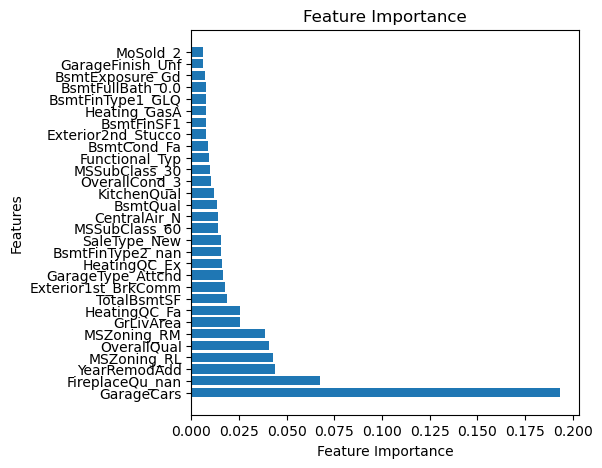

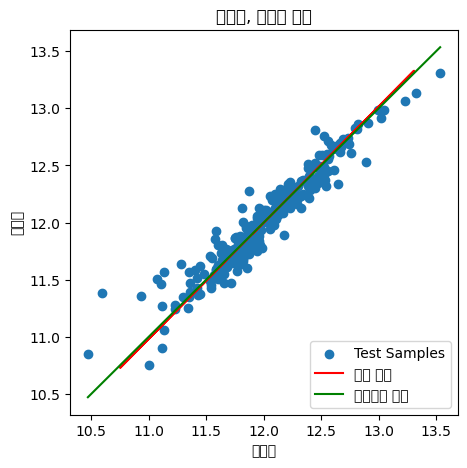

In [60]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# XGBoost 모델
model_XGBoost = xgb.XGBRegressor(max_depth=3, n_estimators=600, learning_rate=0.1)
model_XGBoost.fit(X_train, y_train)
model_val(model_XGBoost, X_train, y_train)
feature_importance(model_XGBoost, X_train, 30)
visualize_model_predictions(model_XGBoost, X_test, y_test)

In [61]:
submission_test=test.drop('SalePrice',axis=1)
submission_y_pred = model_XGBoost.predict(submission_test)
submission = pd.DataFrame()
submission['Id'] = test.index
submission['SalePrice'] = np.expm1(submission_y_pred)
# submission.to_csv(r"C:\Users\USER\Desktop\캐글 모델링\boston house\submission\6_submit.csv", index=False)

OSError: Cannot save file into a non-existent directory: 'C:\Users\USER\Desktop\캐글 모델링\boston house\submission'